# 13 Question


In [2]:
# Import standard Python data science libraries

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
sns.set()

# Import classes from scikit-learn for logistic regression, LDA, QDA, and KNN classification
# Import convenience function for computing confusion matrices 
# Import OneHotEncoder and StandardScaler for data pre-processing
# Import Pipeline, ColumnTransformer to encapsulate pre-processing heterogenous data and fitting
# into a single estimator
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would use the StatsModels Formula API
import statsmodels.api as sm
import statsmodels.formula.api as smf

weekly_filepath = "Weekly.csv"
weekly = pd.read_csv(weekly_filepath)
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


## 13(a)

In [3]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [4]:
weekly["Direction"].value_counts()

Up      605
Down    484
Name: Direction, dtype: int64

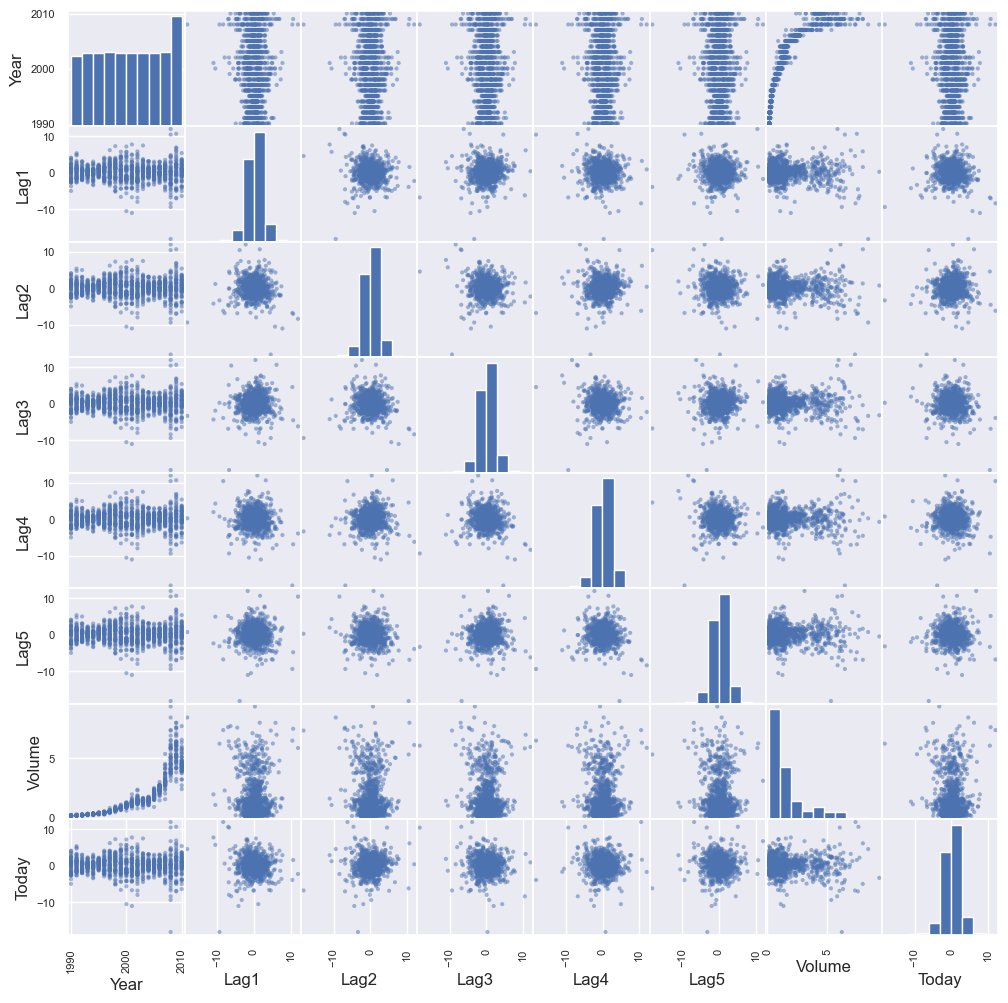

In [12]:
pd.plotting.scatter_matrix(weekly, diagonal='hist', figsize=(12, 12))
plt.show()

The summary statistics and scatterplot matrix, shows no clear linear relationships between variables they don't appear to be any obvious patterns accept from the fact that the volume of shares traded each week has grown quite a lot from 1990 to 2010. however, Looking more closely at the scatterplot of just volume over the time, we can see that the number of shares traded each week has grown exponentially over the 21 years covered by the data.

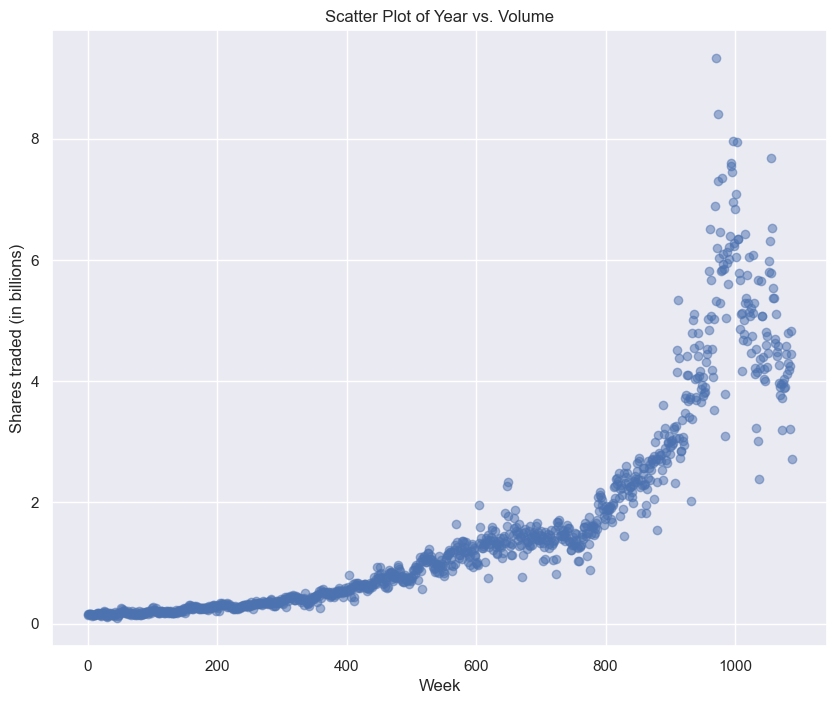

In [15]:
plt.figure(figsize=(10, 8))
plt.scatter(weekly.index, weekly['Volume'], alpha=0.5)
plt.title('Scatter Plot of Year vs. Volume')
plt.xlabel('Week')
plt.ylabel('Shares traded (in billions)')
plt.grid(True)
plt.show()

In [16]:
weekly.corr()

C:\Users\nihar\AppData\Local\Temp\ipykernel_29892\2100277423.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  weekly.corr()


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Lastly, examining the correlation matrix reveals that each lag variable is only weakly correlated with today's returns, with coefficients close to 0. The notable correlation of 0.842 between Volume and Year aligns with the strong correlation observed in the scatter plot.

## 13(b)

In [19]:
weekly['Direction'] = pd.Categorical(weekly['Direction']).codes

# Convert all other variables to numeric format
weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']] = weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']].apply(pd.to_numeric)

# Fit logistic regression model
model = sm.Logit(weekly['Direction'], sm.add_constant(weekly[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]))
result = model.fit()
result.summary()


Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                0.006580
Time:                        12:10:39   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.030       0.006       0.111
Lag3          -0.0161      0.027     -0.602      0.547      -0.068       0.036
Lag4          -0.0278      0.026     -1.050      0.294      -0.080       0.024
Lag5          -0.0145      0.026     -0.549      0.583      -0.066       0.037
Volume        -0.0227      0.037     -0.616      0.538      -0.095       0.050
==============================================================================
"""

In the logistic regression model with Direction as the response variable and the lag variables (Lag1 through Lag5) plus Volume as predictors, only Lag2 is statistically significant at the 5% significance level, with a p-value of 0.030. This suggests evidence to reject the null hypothesis that Lag2 is not related to Direction, in favor of an association between Lag2 and Direction. However, Lag1 is not statistically significant at the 5% level, with a p-value of 0.118. While it is somewhat near the border of significance at the 10% level, it does not reach the conventional threshold for statistical significance. None of the other predictors (Lag3, Lag4, Lag5, Volume) appear to be statistically significant in predicting Direction.



## 13(c)

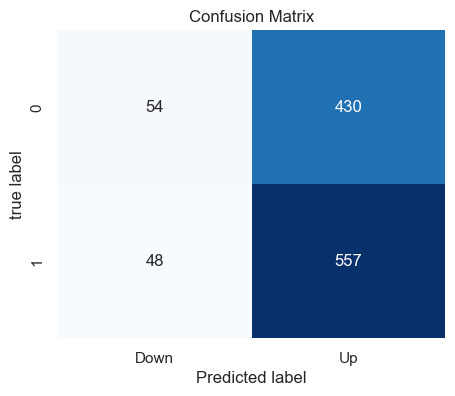

In [33]:

# Create the confusion matrix
confusion_matrix = pd.crosstab(weekly['Direction'], weekly['Predicted_Direction'])

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix, annot=True, cbar = False, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix')
plt.show()


In [39]:
logit_preds = pd.Series(result.predict()).apply(lambda x: 1 if (x > 0.5) else 0)
(logit_preds == weekly["Direction"]).mean()


0.5610651974288338

The logistic regression model using the five lag variables along with Volume as predictors and a threshold of 0.5 achieved an accuracy of 56.10% on the training data. However, a naive strategy of always predicting up weeks would have resulted in a similar accuracy of 55.56%. The model correctly predicted 92.15% of up weeks but had a high false positive rate of 88.97%, indicating a tendency to incorrectly predict up weeks when the market actually went down. The positive predictive value was 56.45%, suggesting that the model's ability to predict up weeks was only slightly better than chance. Similarly, the negative predictive value was 52.94%, indicating that the model's performance in predicting down weeks was not significantly better than chance. Overall, while the model showed some ability to predict up weeks, it was not substantially better than a simple naive strategy, highlighting the need for further refinement or additional features to improve its performance.

## 13(d)

In [46]:
train_mask = (weekly["Year"] < 2009)

In [53]:
# Using the Logit class from StatsModels
# First encode response numerically
train_endog = (weekly.loc[train_mask, "Direction"] == 1).astype("int64")
train_exog = sm.add_constant(weekly.loc[train_mask, "Lag2"])
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:                0.003076
Time:                        12:59:47   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.029      2.024      0.043       0.002       0.114
==============================================================================
"""

In [54]:
#use the model to predict test values
test_exog = sm.add_constant(weekly.loc[~train_mask, "Lag2"])
test_endog = weekly.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: 1 if (x > 0.5) else 0)

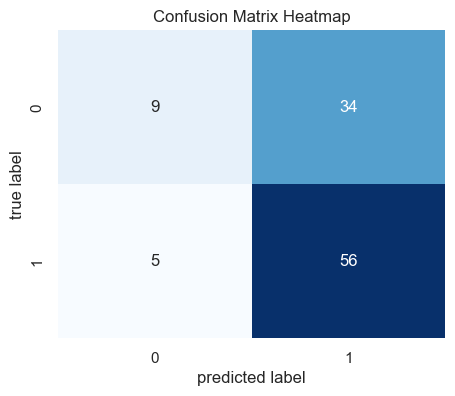

In [64]:
from sklearn.metrics import confusion_matrix as cm
# Create the confusion matrix
conf_matrix = cm(test_endog, logit_test_preds)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cbar = False, cmap='Blues', fmt='d')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [65]:
(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()

0.625

In [67]:
(weekly.loc[~train_mask, "Direction"] == 1).mean()

0.5865384615384616

## 13(e)

In [83]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

In [84]:
# Fit the LDA model using the training set
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

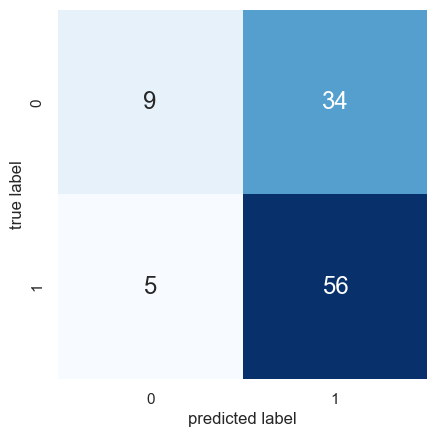

In [86]:
# Make predictions on test data and evaluate the fit
y_pred = lda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, cmap='Blues', ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = lda_clf.classes_, yticklabels = lda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [87]:
lda_clf.score(X_test, y_test)

0.625

After applying linear discriminant analysis (LDA) to the data from 1990 through 2008 using only Lag2 as the predictor, the resulting confusion matrix mirrored that of the logistic regression model from part (d). This indicates similar performance between the two models in predicting market direction. The LDA model correctly predicted the market direction for 62.5% of the weeks in the held-out data (2009 and 2010), representing a modest improvement over random guessing. However, this improvement is still relatively small, being less than 10% better than a naive strategy of predicting every week as an up week. The model's true positive rate was 0.622, indicating the proportion of actual up weeks correctly predicted as up, while the false positive rate was 0.364, indicating the proportion of actual down weeks incorrectly predicted as up. The positive predictive value was 0.611, denoting the proportion of predicted up weeks that were actually up, and the negative predictive value was 0.625, representing the proportion of predicted down weeks that were actually down.

## 13(f)

In [88]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

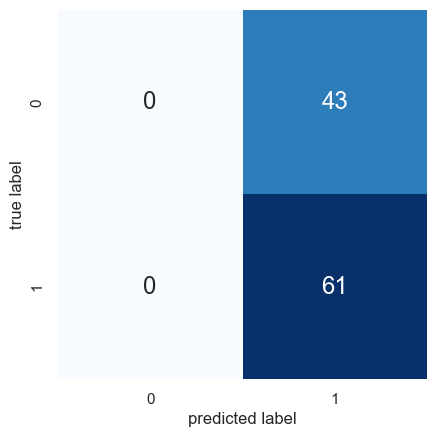

In [90]:
# Make predictions on test data and evaluate the fit
y_pred = qda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, cmap='Blues', ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [91]:
qda_clf.score(X_test, y_test)

0.5865384615384616

After applying Quadratic Discriminant Analysis (QDA) to the data from 1990 through 2008 using only Lag2 as the predictor, the model predicted that every week in 2009 and 2010 would be an up week, resulting in a correct prediction rate of 58.7% for the held-out data. This accuracy is no better than chance and is equivalent to naively predicting that every week will be an up week. The model's true positive rate (sensitivity) was 1.0, indicating that all actual up weeks were correctly predicted as up, while the false positive rate was also 1.0, indicating that all actual down weeks were incorrectly predicted as up. The positive predictive value (precision) was 0.587, reflecting the proportion of predicted up weeks that were actually up. Given these results, further evaluation and testing on a larger dataset would be necessary to assess the QDA model's performance compared to other models.

## 13(g)

In [100]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "Lag2"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "Lag2"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the QDA model using the training set
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

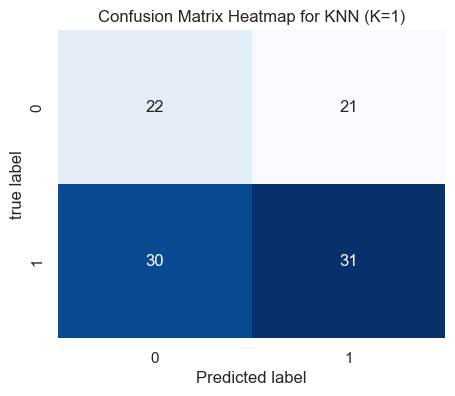

In [112]:
y_pred = knn_1_clf.predict(X_test)
# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_knn, annot=True, cbar = False, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix Heatmap for KNN (K=1)')
plt.show()

In [104]:
knn_1_clf.score(X_test, y_test)

0.5096153846153846

After performing k-nearest neighbors classification with k=1 on the data from 1990 through 2008 using only Lag2 as the predictor, the model correctly predicted the market direction for 50% of the weeks in the held-out data (2009 and 2010). This performance is essentially no better than random guessing and worse than simply predicting that every week will be an up week. Continuing with the convention from part (c) that an up week is a positive result, the true positive rate (sensitivity) is 0.505, indicating the proportion of actual up weeks correctly predicted as up. The false positive rate is 0.523, indicating the proportion of actual down weeks incorrectly predicted as up. The positive predictive value (precision) is 0.50, reflecting the proportion of predicted up weeks that were actually up. The negative predictive value is 0.538, representing the proportion of predicted down weeks that were actually down.

## 13(h)

In [105]:
d={'KNN':[knn_1_clf.score(X_test, y_test)],
   'LDA': [lda_clf.score(X_test, y_test)],
   'Logit': [(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()], 
   'QDA': [qda_clf.score(X_test, y_test)]}
df = pd.DataFrame(data=d,index=["Accuracy"]).T.sort_values(by='Accuracy',ascending=False)
df

,Accuracy
LDA,0.625000
Logit,0.625000
QDA,0.586538
KNN,0.509615


## 13(i)

In [107]:
weighted_lag_avg = 0.4*weekly["Lag1"] + 0.35*weekly["Lag2"] + 0.15*weekly["Lag3"] + 0.05*weekly["Lag4"] + 0.05*weekly["Lag5"]
weekly["weighted_lag_avg"] = weighted_lag_avg
weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,Predicted_Direction,weighted_lag_avg
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,0,Up,0.10055
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,0,Up,0.20515
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,1,Up,-1.12070
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,1,Down,0.58290
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,1,Up,1.15560


In [108]:
weekly[["Today", "weighted_lag_avg"]].corr()

,Today,weighted_lag_avg
Today,1.000000,-0.037241
weighted_lag_avg,-0.037241,1.000000


Computing the correlation between the weighted average and the value of the current week's return reveals a very weak correlation. This correlation is even weaker than the correlations between the current week's return and each of the lag variables individually. This suggests that the weighting method might not be very useful. Nonetheless, I will proceed to test each of the classification methods using this transformation of the predictors. I will begin with logistic regression.

In [120]:
# First encode response numerically
train_endog = (weekly.loc[train_mask, "Direction"] == 1).astype(int)
train_exog = sm.add_constant(weekly.loc[train_mask, "weighted_lag_avg"])

logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
logit_res.summary()



Optimization terminated successfully.
         Current function value: 0.687529
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Sun, 25 Feb 2024   Pseudo R-squ.:               0.0002054
Time:                        14:24:04   Log-Likelihood:                -677.22
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                    0.5978
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2135      0.064      3.312      0.001       0.087       0.340
weighted_lag_avg    -0.0282      0.053     -0.527      0.599      -0.133       0.077
====================================================================================
"""

In [122]:
test_exog = sm.add_constant(weekly.loc[~train_mask, "weighted_lag_avg"])
test_endog = weekly.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: 1 if (x > 0.5) else 0)

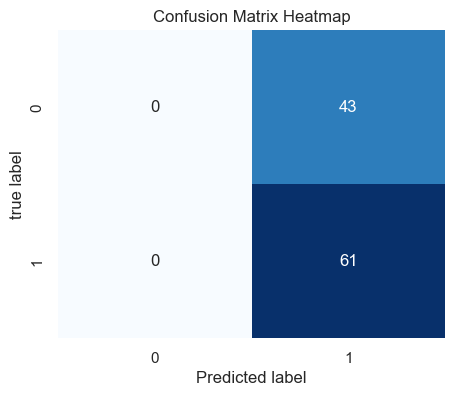

In [131]:
conf_matrix = confusion_matrix(test_endog, logit_test_preds)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, cbar = False, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [127]:
(logit_test_preds == weekly.loc[~train_mask, "Direction"]).mean()

0.5865384615384616

The logistic regression model with the weighted average feature did not yield promising results, performing similarly to always predicting an up market. The coefficient for weighted_lag_avg was not statistically significant, with a p-value of 0.599, suggesting it did not improve the model. This aligns with the fact that the weighted average is a linear combination of variables, and Lag2 was the only significant predictor in the logistic regression model. Thus, including the weighted average, which contains non-significant variables, is unlikely to enhance the model's performance. Despite this, I will continue to explore the remaining methods using the weighted_lag_avg before considering other predictor combinations. The next step is linear discriminant analysis.

In [128]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Fit the LDA model using the training set
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis()

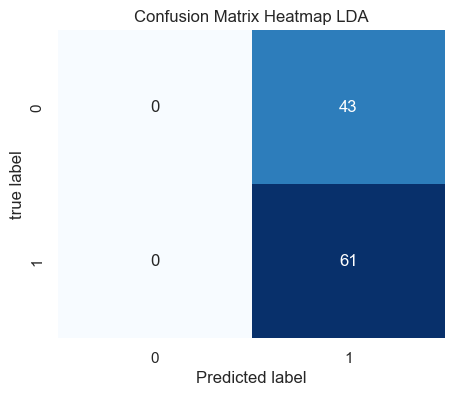

In [132]:
y_pred = lda_clf.predict(X_test)
# Compute confusion matrix
conf_matrix_lda = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_lda, annot=True, cbar = False, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix Heatmap LDA')
plt.show()



In [133]:
lda_clf.score(X_test, y_test)

0.5865384615384616

In [134]:
# First separate out the training and test sets
X_train = weekly.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = weekly.loc[train_mask, "Direction"]
X_test = weekly.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = weekly.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis()

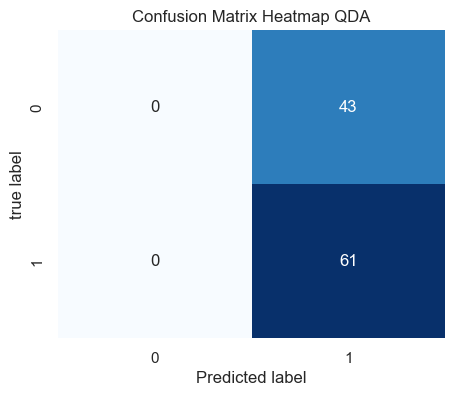

In [135]:
y_pred = qda_clf.predict(X_test)
# Compute confusion matrix
conf_matrix_qda = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_qda, annot=True, cbar = False, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('true label')
plt.title('Confusion Matrix Heatmap QDA')
plt.show()

With a stricter probability threshold of 60% for predicting an up week, the overall prediction accuracy decreases to 48.1%. However, the false positive rate improves significantly to , which is a notable enhancement over the false positive rate of 1 from part (f). Moreover, the positive predictive value increases to , indicating an improvement over the value of 0.587 from part (f). This suggests that for risk-averse investors who prefer to invest only when there is a high probability of the market going up, using QDA with the weighted average of lag variables and a stricter probability threshold could be a promising approach. The final method to evaluate is k-nearest neighbors.

## 14(a)

In [255]:
Auto=pd.read_csv("C:/Users/nihar/OneDrive/Desktop/Predictive Modeling/Data Sets/Auto.data", delim_whitespace=True, na_values = [" "])
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [256]:
Auto["origin"] = Auto["origin"].map({1: "American", 2: "European", 3: "Japanese"})
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,American,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,American,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,American,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,American,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,American,ford torino


In [257]:
mpg_med = (Auto["mpg"] > Auto["mpg"].median()).map({False: "Below", True: "Above"})
Auto["mpg_med"] = mpg_med
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,mpg_med
0,18.0,8,307.0,130.0,3504.0,12.0,70,American,chevrolet chevelle malibu,Below
1,15.0,8,350.0,165.0,3693.0,11.5,70,American,buick skylark 320,Below
2,18.0,8,318.0,150.0,3436.0,11.0,70,American,plymouth satellite,Below
3,16.0,8,304.0,150.0,3433.0,12.0,70,American,amc rebel sst,Below
4,17.0,8,302.0,140.0,3449.0,10.5,70,American,ford torino,Below


## 14(b)

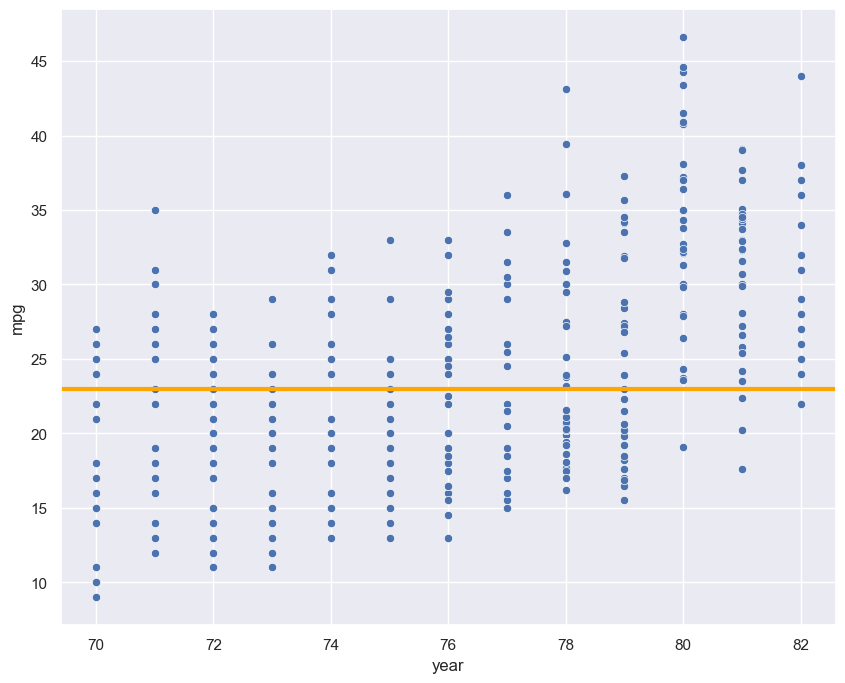

In [258]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.scatterplot(x = "year", y = "mpg", data = Auto, ax = ax)
ax.axhline(y = Auto["mpg"].median(), color = "orange", linewidth = 3);

The scatterplot of mpg vs. year suggests that newer cars in the dataset tend to be more fuel-efficient. While the manufacture year may not be as prominent as the other four quantitative variables (cylinders, displacement, horsepower, and weight), it still appears to be a valuable inclusion. Therefore, it seems worthwhile to include the manufacture year in your analysis to see if it improves the predictive power of your model.

C:\Users\nihar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


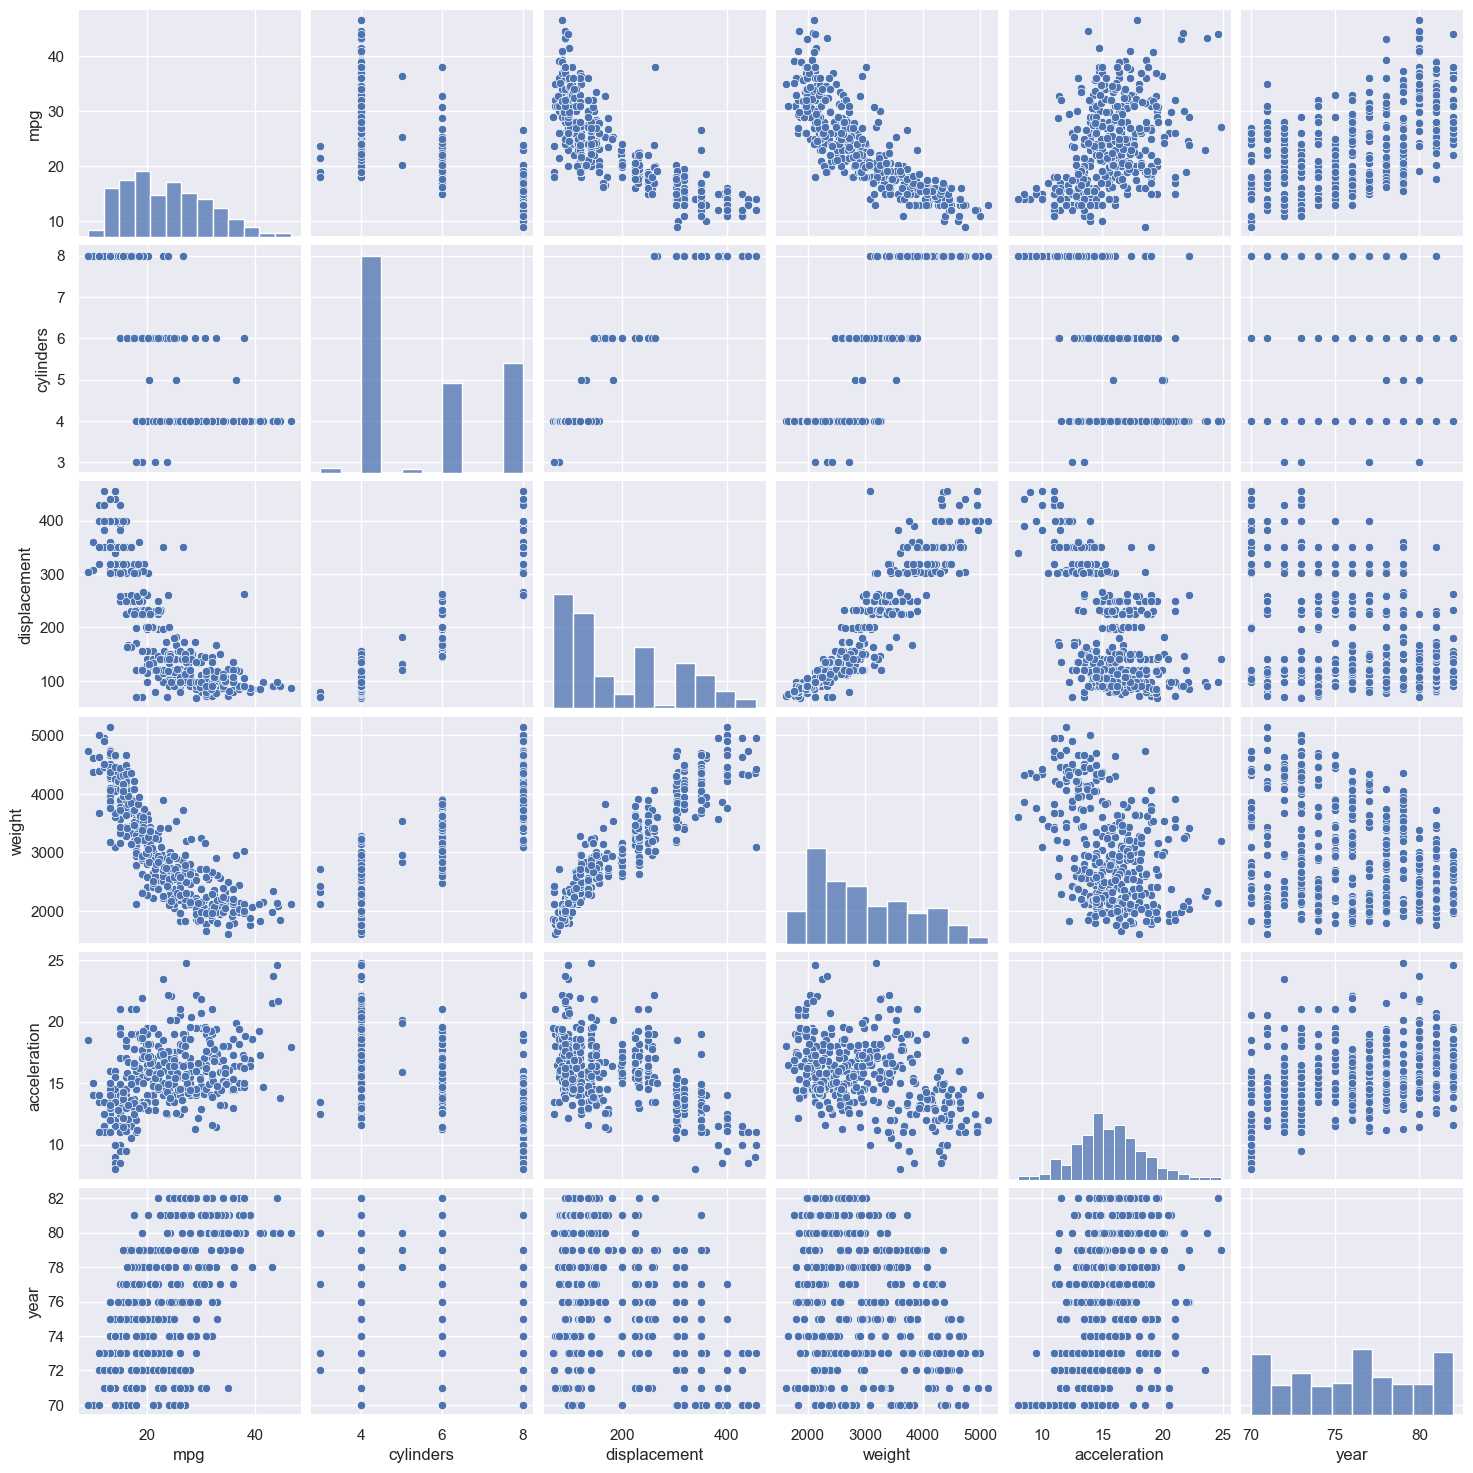

In [259]:
sns.pairplot(Auto)

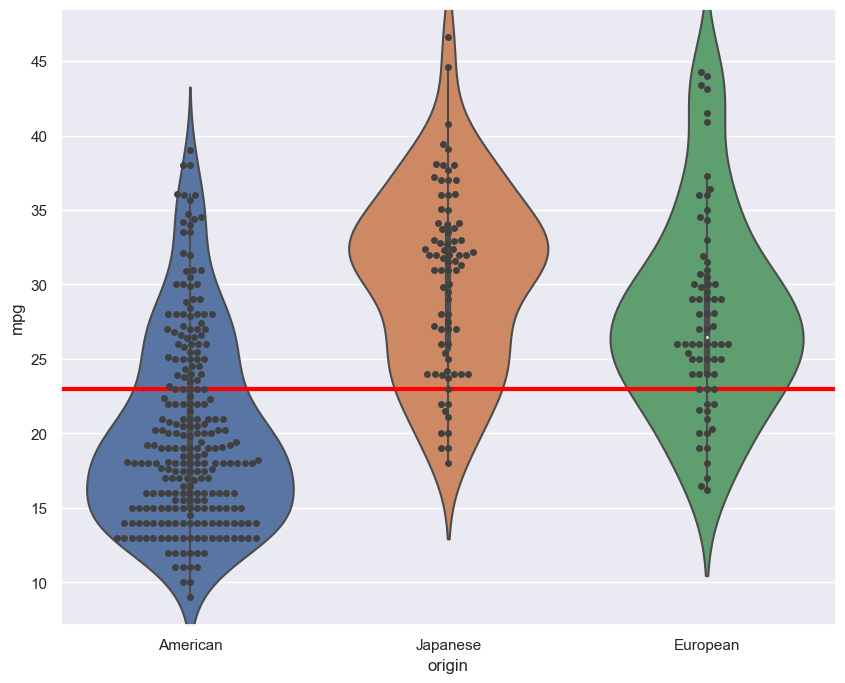

In [260]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.violinplot(x = "origin", y = "mpg", data = Auto, ax = ax)
sns.swarmplot(x = "origin", y = "mpg", data = Auto, ax = ax, color = ".25")
ax.axhline(y = Auto["mpg"].median(), color = "red", linewidth = 3);


The graphical analysis of the data has revealed several key insights that will inform the modeling process for predicting mpg_med. From the scatterplot, it is evident that certain variables like cylinders, displacement, horsepower, and weight exhibit distinct patterns that can help predict fuel efficiency. These variables show a clear association with mpg_med, with cars having lower mpg_med values generally having higher values for cylinders, displacement, horsepower, and weight. Additionally, the scatterplot of mpg versus year indicates that newer cars tend to have higher fuel efficiency, suggesting that the manufacture year might also be a relevant predictor. Furthermore, the violinplot overlaid with a swarmplot comparing mpg values for each car by country of origin reveals a significant difference, with American cars generally exhibiting lower fuel efficiency compared to European and Japanese cars. This suggests that the origin of the car could also be a useful predictor for mpg_med. Considering these findings, the final model will include all predictors except for acceleration and name, and exclude mpg, which was used to create the classification label.

## 14(c)

In [277]:
# Replace '?' with NaN
Auto.replace('?', np.nan, inplace=True)

# Convert columns to numeric
Auto = Auto.apply(pd.to_numeric, errors='ignore')

# Drop rows with missing values
Auto.dropna(inplace=True)

# Split the data into training and test sets
X = Auto[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']]
y = Auto['mpg_med']

In [278]:
# a convenient function for splitting data sets
X_train, X_test, y_train, y_test = train_test_split(Auto, Auto["mpg_med"], test_size = 0.25, random_state = 312)

## 14(d)

In [279]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

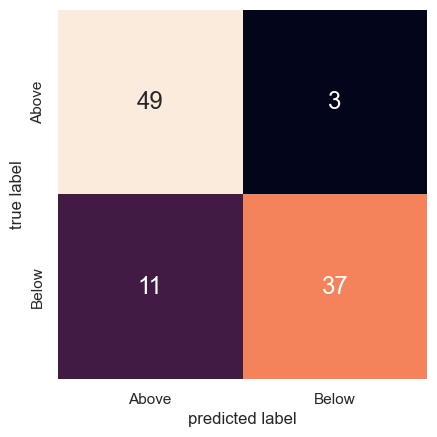

In [280]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [281]:
1 - clf.score(X_test, y_test)

0.14

In [282]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", LinearDiscriminantAnalysis())])

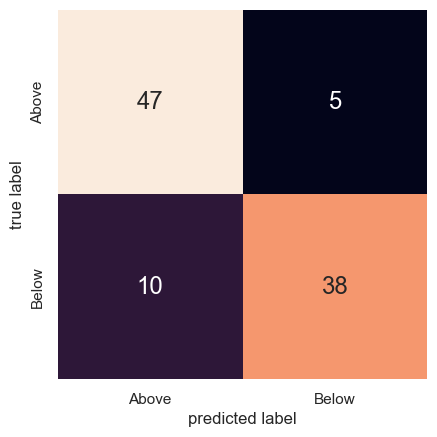

In [283]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [284]:
1 - clf.score(X_test, y_test)

0.15000000000000002

## 14(e)

In [285]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", QuadraticDiscriminantAnalysis())])

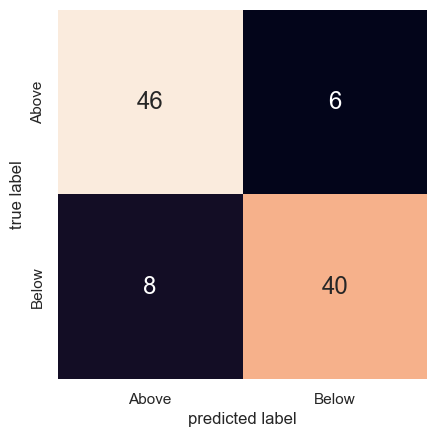

In [286]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [287]:
1 - clf.score(X_test, y_test)

0.14

In [288]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), ("classifier", QuadraticDiscriminantAnalysis())])

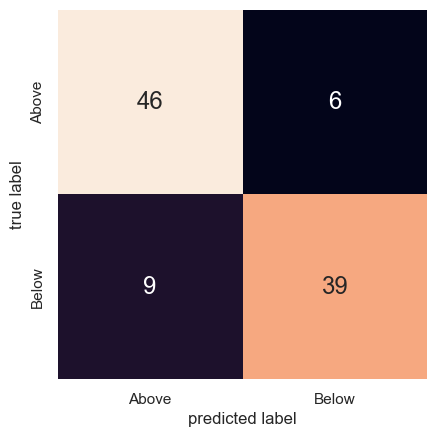

In [289]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [290]:
1 - clf.score(X_test, y_test)

0.15000000000000002

## 14(f)

In [291]:
categorical_features = ["origin"]
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs"))])

C:\Users\nihar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\nihar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


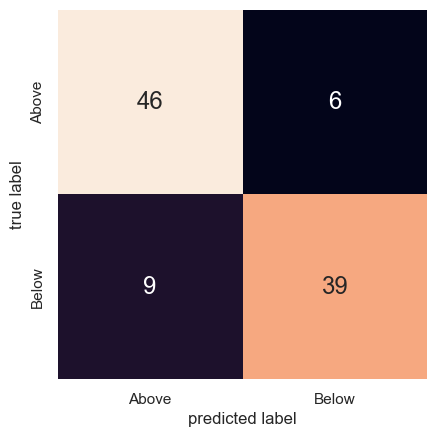

In [292]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [293]:
1 - clf.score(X_test, y_test)

0.15000000000000002

In [294]:
# Exclude the origin and year columns
categorical_features = []
categorical_transformer = Pipeline([("onehot", OneHotEncoder(drop = "first"))])
numerical_features = ["cylinders", "displacement", "horsepower", "weight"]
preprocessor = ColumnTransformer([("cat", categorical_transformer, categorical_features),
                                 ("num", "passthrough", numerical_features)])
clf = Pipeline([("preprocessor", preprocessor), 
                ("classifier", LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 500))])

C:\Users\nihar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


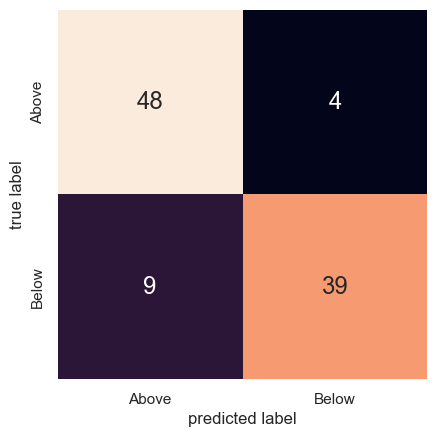

In [295]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf["classifier"].classes_, yticklabels = clf["classifier"].classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [296]:
1 - clf.score(X_test, y_test)

0.13

## 14(g)

In [297]:
numerical_features = ["cylinders", "displacement", "horsepower", "weight", "year"]
numerical_transformer = Pipeline([("standardize", StandardScaler())])
preprocessor = ColumnTransformer([("num", numerical_transformer, numerical_features)])

np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("preprocessor", preprocessor), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test, y_test)
pd.Series(knn_errors)

1     0.12
3     0.11
5     0.13
7     0.09
9     0.11
11    0.12
13    0.14
15    0.13
17    0.14
19    0.14
dtype: float64

## 16


In [232]:
boston_filepath = "https://raw.githubusercontent.com/namiyousef/ai_hack_2021/main/data/Boston_Housing_Market_Challenge/boston_fixed.csv"
index_cols = ["TOWN", "TRACT"]
data_cols = ["TOWN", "TRACT", "CMEDV", "CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX",
            "PTRATIO", "B", "LSTAT"]
boston = pd.read_csv(boston_filepath, index_col = index_cols, usecols = data_cols)
boston.head()

CMEDV     CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  \
TOWN      TRACT                                                                
Arlington 3567    29.9  0.06642  0.0   4.05     0  0.51  6.860  74.4  2.9153   
          3566    24.6  0.05425  0.0   4.05     0  0.51  6.315  73.4  3.3175   
          3565    23.2  0.07022  0.0   4.05     0  0.51  6.020  47.2  3.5549   
          3564    29.4  0.06664  0.0   4.05     0  0.51  6.546  33.1  3.1323   
          3563    22.6  0.08447  0.0   4.05     0  0.51  5.859  68.7  2.7019   

                 RAD  TAX  PTRATIO       B  LSTAT  
TOWN      TRACT                                    
Arlington 3567     5  296     16.6  391.27   6.92  
          3566     5  296     16.6  395.60   6.29  
          3565     5  296     16.6  393.23  10.11  
          3564     5  296     16.6  390.96   5.33  
          3563     5  296     16.6  393.23   9.64

In [233]:
crim_med = (boston["CRIM"] > boston["CRIM"].median()).map({False: "Below", True: "Above"})
boston["crim_med"] = crim_med
boston.head()

CMEDV     CRIM   ZN  INDUS  CHAS   NOX     RM   AGE     DIS  \
TOWN      TRACT                                                                
Arlington 3567    29.9  0.06642  0.0   4.05     0  0.51  6.860  74.4  2.9153   
          3566    24.6  0.05425  0.0   4.05     0  0.51  6.315  73.4  3.3175   
          3565    23.2  0.07022  0.0   4.05     0  0.51  6.020  47.2  3.5549   
          3564    29.4  0.06664  0.0   4.05     0  0.51  6.546  33.1  3.1323   
          3563    22.6  0.08447  0.0   4.05     0  0.51  5.859  68.7  2.7019   

                 RAD  TAX  PTRATIO       B  LSTAT crim_med  
TOWN      TRACT                                             
Arlington 3567     5  296     16.6  391.27   6.92    Below  
          3566     5  296     16.6  395.60   6.29    Below  
          3565     5  296     16.6  393.23  10.11    Below  
          3564     5  296     16.6  390.96   5.33    Below  
          3563     5  296     16.6  393.23   9.64    Below

In [234]:
boston.corr()["CRIM"]

C:\Users\nihar\AppData\Local\Temp\ipykernel_29892\3769878102.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  boston.corr()["CRIM"]


CMEDV     -0.389582
CRIM       1.000000
ZN        -0.200469
INDUS      0.406583
CHAS      -0.055892
NOX        0.420972
RM        -0.219247
AGE        0.352734
DIS       -0.379670
RAD        0.625505
TAX        0.582764
PTRATIO    0.289946
B         -0.385064
LSTAT      0.455621
Name: CRIM, dtype: float64

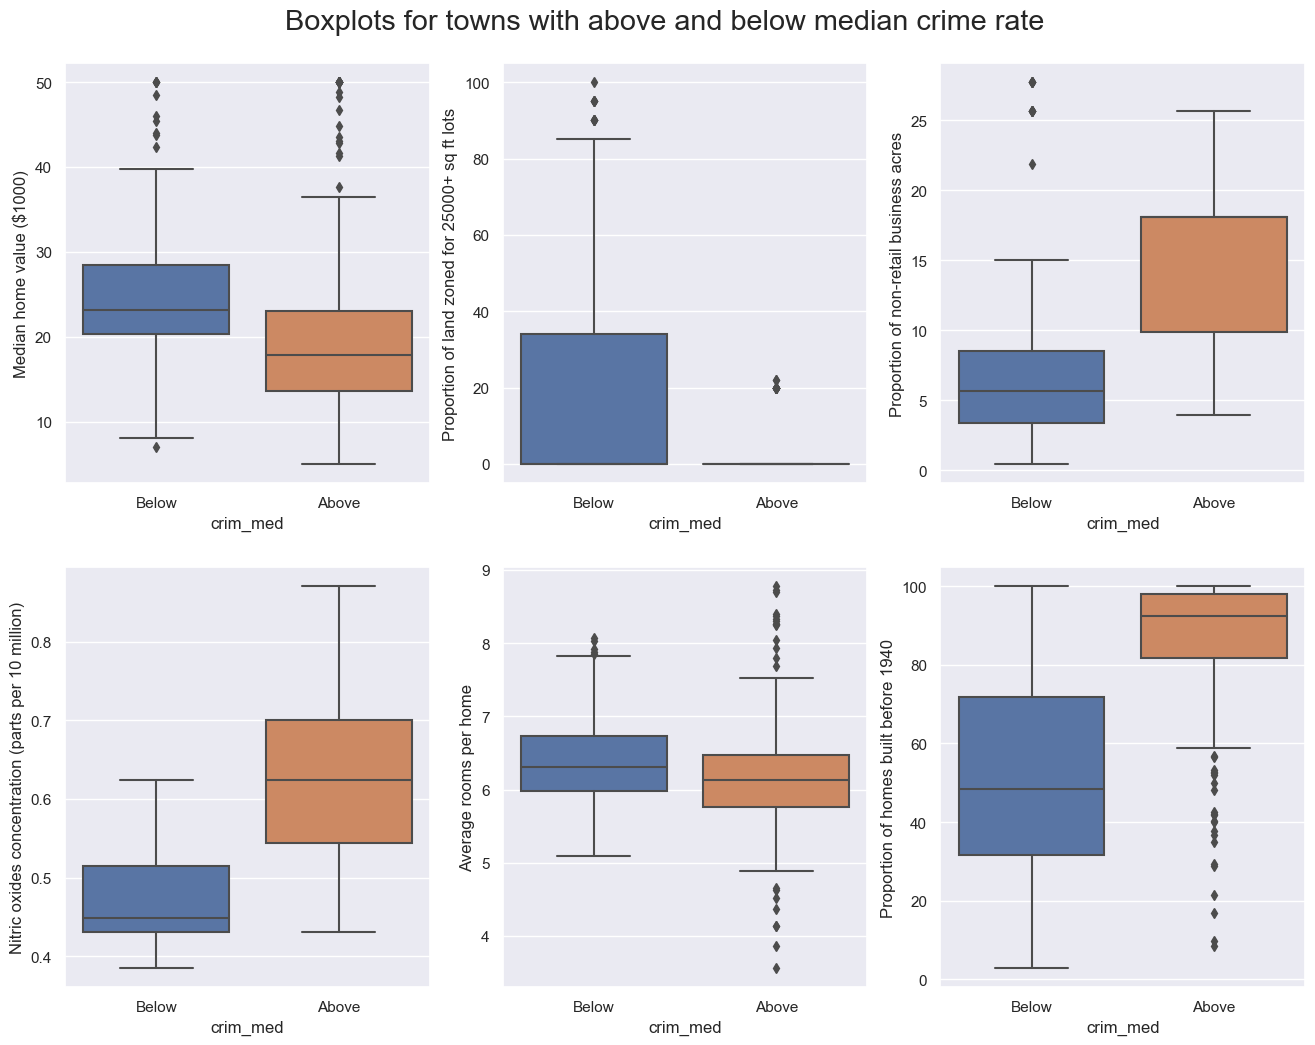

In [235]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 12))
sns.boxplot(x = "crim_med", y = "CMEDV", data = boston, ax = axes[0, 0])
axes[0, 0].set_ylabel("Median home value ($1000)")
sns.boxplot(x = "crim_med", y = "ZN", data = boston, ax = axes[0, 1])
axes[0, 1].set_ylabel("Proportion of land zoned for 25000+ sq ft lots")
sns.boxplot(x = "crim_med", y = "INDUS", data = boston, ax = axes[0, 2])
axes[0, 2].set_ylabel("Proportion of non-retail business acres")
sns.boxplot(x = "crim_med", y = "NOX", data = boston, ax = axes[1, 0])
axes[1, 0].set_ylabel("Nitric oxides concentration (parts per 10 million)")
sns.boxplot(x = "crim_med", y = "RM", data = boston, ax = axes[1, 1])
axes[1, 1].set_ylabel("Average rooms per home")
sns.boxplot(x = "crim_med", y = "AGE", data = boston, ax = axes[1, 2])
axes[1, 2].set_ylabel("Proportion of homes built before 1940")
fig.suptitle("Boxplots for towns with above and below median crime rate", size = "xx-large", y = 0.925);


The boxplots compare housing-related features between towns with above-median and below-median crime rates. Median home value (CMEDV) appears lower in areas with higher crime rates, indicating a possible link between housing prices and crime. Proportions of land zoned for large lots (ZN) and non-retail business acres (INDUS) are higher in areas with lower crime rates, suggesting a more residential and less industrialized environment in these areas. Nitric oxides concentration (NOX) seems slightly higher in higher crime areas, indicating potentially poorer air quality. Average rooms per home (RM) and proportion of older homes (AGE) show no clear trend between the two crime rate groups. These insights can help in understanding the relationship between housing characteristics and crime rates, aiding policymakers and urban planners in making informed decisions.

In [236]:
X_train, X_test, y_train, y_test = train_test_split(boston, boston["crim_med"], test_size = 0.25, random_state = 312)

In [237]:
not_chas = boston.columns.drop(["CHAS", "CRIM", "crim_med"])
moderate_corr = boston.corr().loc[(boston.corr()["CRIM"].abs() > 0.3), "CRIM"].index.drop("CRIM")

C:\Users\nihar\AppData\Local\Temp\ipykernel_29892\3407009205.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  moderate_corr = boston.corr().loc[(boston.corr()["CRIM"].abs() > 0.3), "CRIM"].index.drop("CRIM")


In [241]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

C:\Users\nihar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[62,  4],
       [ 7, 54]], dtype=int64)

In [242]:
1 - clf.score(X_test[not_chas], y_test)

0.08661417322834641

When using logistic regression to predict crim_med using all predictors except CHAS, we obtained an overall test error of 8.66%. This error rate appears promising for the initial model. Next, we will proceed with the smaller subset of predictors and explore other models to potentially enhance performance.

In [243]:
clf = LogisticRegression(penalty = "none", solver = "lbfgs", max_iter = 10000)
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
confusion = confusion_matrix(y_test, y_pred)
confusion

C:\Users\nihar\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


array([[61,  5],
       [ 9, 52]], dtype=int64)

In [244]:
1 - clf.score(X_test[moderate_corr], y_test)

0.11023622047244097

The logistic regression model using fewer predictors (CMEDV, INDUS, NOX, AGE, DIS, RAD, TAX, B, and LSTAT) performed slightly worse, with an overall test error of 11.02%. It had a positive predictive value of 0.871, which is a slight decrease from the model with more predictors. However, the true positive rate is slightly better, at 0.924. This suggests that the model with fewer predictors is better at correctly identifying suburbs with above-median crime rates, but it is less precise overall compared to the model with more predictors.

In [245]:
#LDA
clf = LinearDiscriminantAnalysis()
clf.fit(X_train[moderate_corr], y_train)
y_pred = clf.predict(X_test[moderate_corr])
confusion_lda = confusion_matrix(y_test, y_pred)
confusion_lda

array([[52, 14],
       [ 4, 57]], dtype=int64)

In [246]:
1 - clf.score(X_test[moderate_corr], y_test)

0.1417322834645669

In [247]:
# QDA
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train[not_chas], y_train)
y_pred = clf.predict(X_test[not_chas])
confusion_qda = confusion_matrix(y_test, y_pred)
confusion_qda

array([[51, 15],
       [ 1, 60]], dtype=int64)

In [248]:
1 - clf.score(X_test[not_chas], y_test)

0.12598425196850394

It seems like the quadratic discriminant analysis (QDA) model is performing well, especially in terms of its positive predictive value. This means that it is effective at correctly identifying suburbs with above-median crime rates. If minimizing false positives (i.e., suburbs incorrectly classified as above-median crime rate) is a priority, then the QDA model could be a good choice.

In [249]:
# KNN Classification
np.random.seed(312)
k_vals = list(range(1, 21, 2))
knn_errors = {}
confusion_matrices = {}
for k in k_vals:
    clf = Pipeline([("standardize", StandardScaler()), ("classifier", KNeighborsClassifier(n_neighbors = k))])
    clf.fit(X_train[not_chas], y_train)
    y_pred = clf.predict(X_test[not_chas])
    confusion_matrices[k] = confusion_matrix(y_test, y_pred)
    knn_errors[k] = 1 - clf.score(X_test[not_chas], y_test)
pd.Series(knn_errors)

1     0.062992
3     0.070866
5     0.070866
7     0.062992
9     0.062992
11    0.086614
13    0.094488
15    0.110236
17    0.141732
19    0.173228
dtype: float64

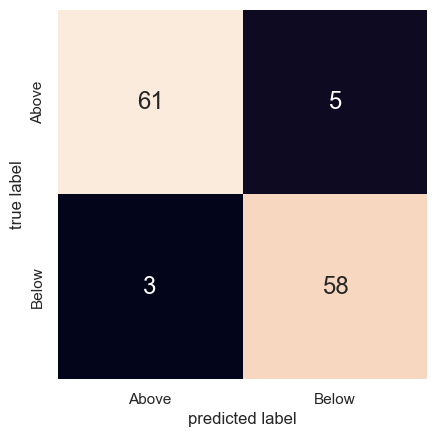

In [250]:
mat = confusion_matrices[1]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

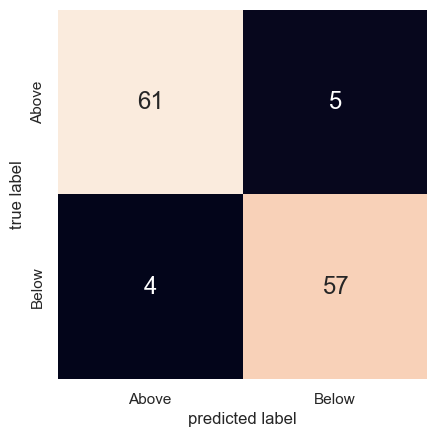

In [251]:
mat = confusion_matrices[3]
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = clf.classes_, yticklabels = clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

It appears that using k-nearest neighbors (KNN) classification with k=3 yields the best overall test error rate among the models and predictor combinations examined so far, with an error rate of 6.3%. This is an improvement over logistic regression using the same predictors. Additionally, KNN with k=3 has the best positive predictive value among the classification models, indicating its effectiveness in correctly identifying suburbs with above-median crime rates. The true positive rate for this model is also comparable to logistic regression using the same predictors.